<a href="https://colab.research.google.com/github/HamedFarahani89/Quantum-Computing-Lab/blob/main/Modern_Hopfield_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.beren.io/2020-11-02-Walkthrough_Hopfield-Networks-Is-All-You-Need/

# Walkthrough of "Hopfield Networks are all you need"

### Loading and Preparing the MNIST Dataset

This section loads the MNIST dataset using PyTorch. The images are:

- Converted to tensors.
- Flattened from 28×28 into 784-dimensional vectors.
- Normalized by a specified `norm_factor` (default is 1, so no scaling).
- Batched using a custom `batch_size` (e.g., 1000).



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from copy import deepcopy
import torch.nn.functional as F

def load_mnist(batch_size,norm_factor=1):
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = torchvision.datasets.MNIST(root='./mnist_data', train=True, download=True, transform=transform)
    print("trainset: ", trainset)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    print("trainloader: ", trainloader)
    trainset = list(iter(trainloader))

    testset = torchvision.datasets.MNIST(root='./mnist_data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
    testset = list(iter(testloader))
    for i,(img, label) in enumerate(trainset):
        trainset[i] = (img.reshape(len(img),784) /norm_factor ,label)
    for i,(img, label) in enumerate(testset):
        testset[i] = (img.reshape(len(img),784) /norm_factor ,label)
    return trainset, testset

trainset, testset = load_mnist(1000)


100%|██████████| 9.91M/9.91M [00:00<00:00, 28.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 745kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 6.31MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.78MB/s]


trainset:  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
trainloader:  <torch.utils.data.dataloader.DataLoader object at 0x793199d9e950>


In [ ]:
trainset[0][0][0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
trainset[0][0].shape

torch.Size([1000, 784])

In [ ]:
trainset[0][0][0].shape

torch.Size([784])

In [ ]:
def binarize(img):
  i = deepcopy(img)
  i[img > 0] = -1
  i[img <=0] = 1
  return i

def zero_bottom_half(img):
  i = deepcopy(img)
  H,W = img.shape
  i[H//2:H,:] = -1
  return i


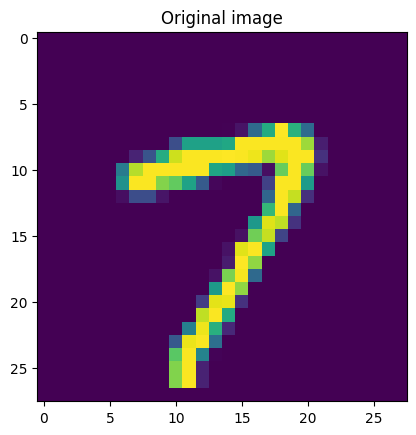

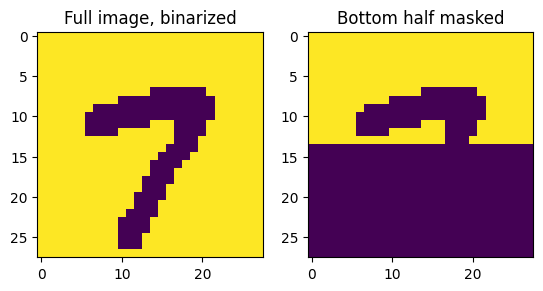

In [ ]:
imgs,labels = trainset[0] # get the image and label seprately

digit = imgs[1,:].reshape(784,1) # choose one of them to check out functions

plt.title("Original image")
plt.imshow(digit.reshape(28,28))
plt.show()

digit = binarize(digit)
halved_digit = zero_bottom_half(digit.reshape(28,28)).reshape(784,1)
plt.subplot(1,2,1)
plt.title("Full image, binarized")
plt.imshow(digit.reshape(28,28))
plt.subplot(1,2,2)
plt.title("Bottom half masked")
plt.imshow(halved_digit.reshape(28,28))
plt.show()

- The Hopfield Network can retrieve a complete image from its corrupted (partial) version by storing the original pattern.
- Since only a single pattern is stored here, there is no interference, and the retrieval is nearly perfect.


tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
torch.Size([784, 784])


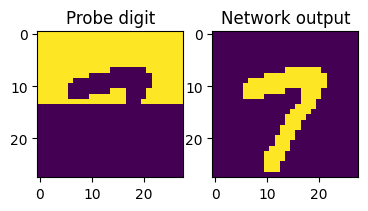

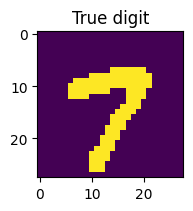

In [ ]:
# Store a single digit in the weights
W = digit @ digit.T
print(W)
print(W.shape)
# perform the hopfield update rule with the probe as the halved digit to retrieve the original
out = binarize(W @ halved_digit)

#plot
plt.subplot(1,3,1)
plt.title("Probe digit")
plt.imshow(halved_digit.reshape(28,28))
plt.subplot(1,3,2)
plt.title("Network output")
plt.imshow(out.reshape(28,28))
plt.show()
plt.subplot(1,3,3)
plt.title("True digit")
plt.imshow(out.reshape(28,28))
plt.show()

### Storing and Retrieving Multiple Patterns in a Hopfield Network

The function:

- Constructs a Hopfield weight matrix `W` by storing `N` binarized MNIST images.
- Each image is reshaped to a column vector and added to the weight matrix using the Hebbian learning rule:  
  **W += x · xᵀ**  
- This simulates storing multiple patterns in memory.



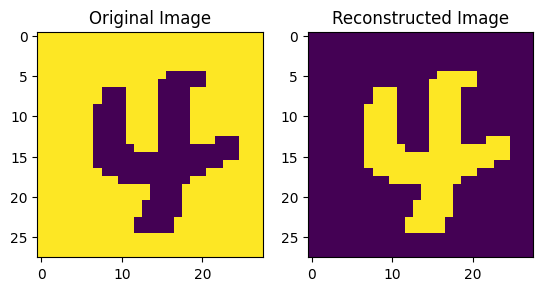

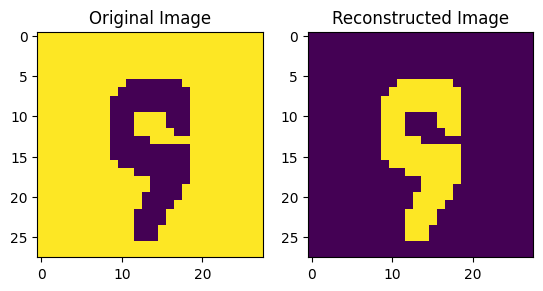

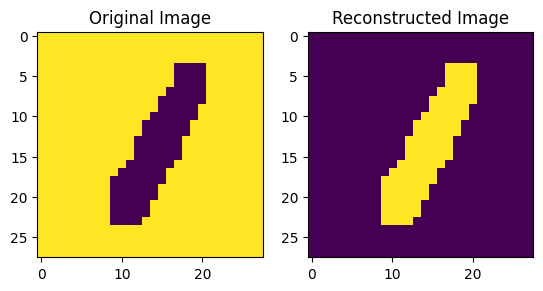

In [ ]:
def store_retrieve_N_images(N):
  # construct weight matrix of N stored images
  W = torch.zeros((784,784))
  for i in range(N):
    digit = binarize(imgs[i,:].reshape(784,1))
    W += digit @ digit.T

  # try to retrieve each image
  for i in range(N):
    digit = binarize(imgs[i,:]).reshape(28,28)
    halved_digit = zero_bottom_half(digit).reshape(784,1)
    out = binarize(W @ halved_digit)
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(digit)
    plt.subplot(1,2,2)
    plt.title("Reconstructed Image")
    plt.imshow(out.reshape(28,28))
    plt.show()

store_retrieve_N_images(3)

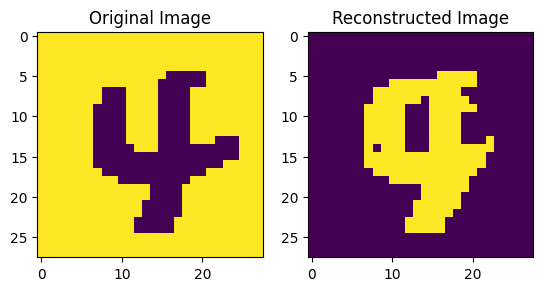

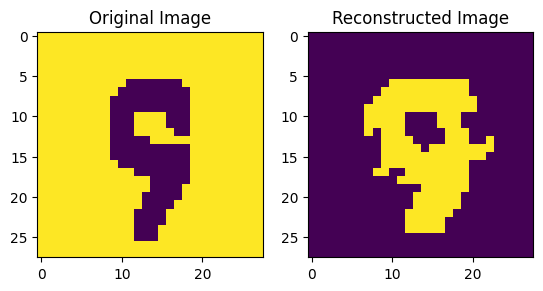

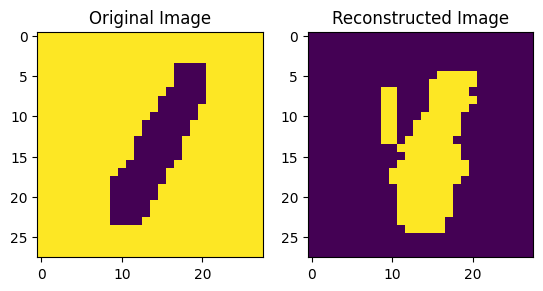

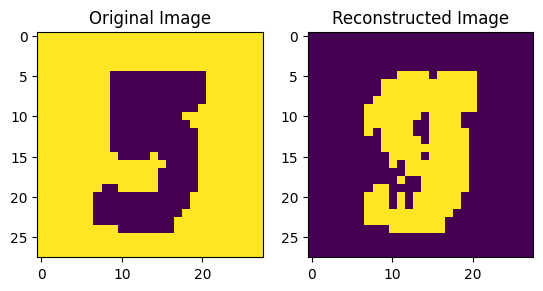

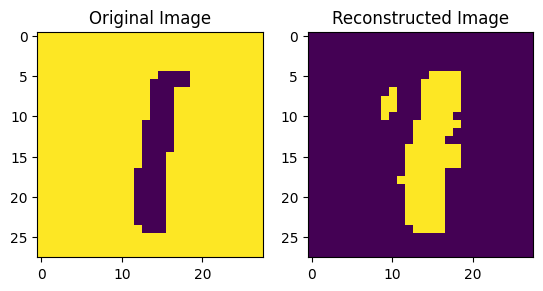

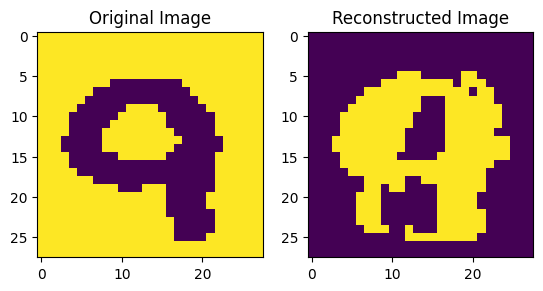

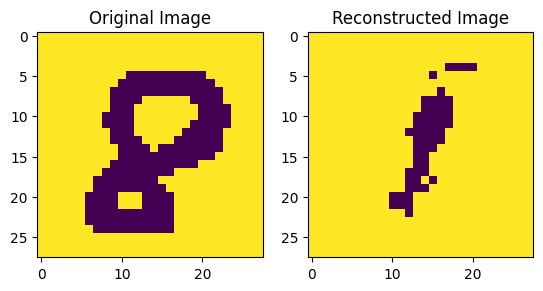

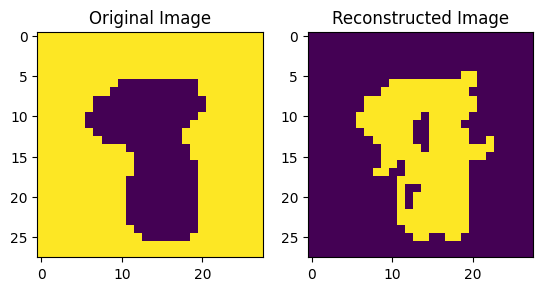

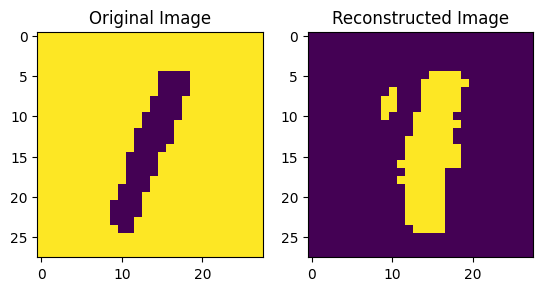

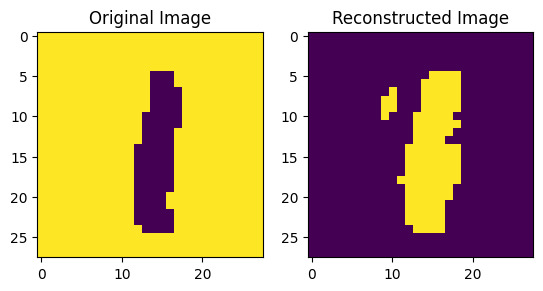

In [ ]:
store_retrieve_N_images(10)

# This problem is not due to the storage capacity of the network, which is much greater than 10, but rather because the inputs are correlated.

# Demircigil

----
# Demircigil Update Rule - Simple Numerical Example

## Initial Setup

- Number of neurons = 2
- Stored patterns (memory):
  $
  x_1 = \begin{bmatrix} 1 \\ 1 \end{bmatrix}, \quad x_2 = \begin{bmatrix} -1 \\ 1 \end{bmatrix}
  $
- Initial neuron state:
  $
  z = \begin{bmatrix} 1 \\ -1 \end{bmatrix}
  $

---

## Step-by-Step Update

### 🔹 Update neuron `i = 0`

1. Create two copies:
   - $ z_{\text{pos}} = [1, -1] $ (set neuron 0 to +1)
   - $ z_{\text{neg}} = [-1, -1] $ (set neuron 0 to -1)

2. Compute energy sums:

#### For $z_{\text{pos}} $:
- $ E_1^+ = x_1^T z_{\text{pos}} = (1)(1) + (1)(-1) = 0 $
- $ E_2^+ = x_2^T z_{\text{pos}} = (-1)(1) + (1)(-1) = -2 $
- Energy sum:
  $
  E_{\text{pos}} = e^{0/10} + e^{-2/10} \approx 1 + 0.8187 = 1.8187
  $

#### For $ z_{\text{neg}} $:
- $ E_1^- = x_1^T z_{\text{neg}} = (1)(-1) + (1)(-1) = -2 $
- $ E_2^- = x_2^T z_{\text{neg}} = (-1)(-1) + (1)(-1) = 0 $
- Energy sum:
  $
  E_{\text{neg}} = e^{-2/10} + e^{0/10} \approx 0.8187 + 1 = 1.8187
  $

**Result:**  
Since $ E_{\text{pos}} = E_{\text{neg}} $, we choose `-1` according to the rule.

Thus:
$
\text{out}[0] = -1
$

---

### 🔹 Update neuron `i = 1`

1. Create two copies:
   - $ z_{\text{pos}} = [1, 1] $ (set neuron 1 to +1)
   - $ z_{\text{neg}} = [1, -1] $ (set neuron 1 to -1)

2. Compute energy sums:

#### For $ z_{\text{pos}} $:
- $ E_1^+ = (1)(1) + (1)(1) = 2 $
- $ E_2^+ = (-1)(1) + (1)(1) = 0 $
- Energy sum:
  $
  E_{\text{pos}} = e^{2/10} + e^{0/10} \approx 1.2214 + 1 = 2.2214
  $

#### For \( z_{\text{neg}} \):
- $ E_1^- = (1)(1) + (1)(-1) = 0 $
- $ E_2^- = (-1)(1) + (1)(-1) = -2 $
- Energy sum:
  $
  E_{\text{neg}} = e^{0/10} + e^{-2/10} \approx 1 + 0.8187 = 1.8187
  $

**Result:**  
Since $ E_{\text{pos}} > E_{\text{neg}} $, we choose `+1`.

Thus:
$
\text{out}[1] = 1
$

---

### Final updated neuron states:

$
\text{out} = \begin{bmatrix} -1 \\ 1 \end{bmatrix}
$

---


In [ ]:
def demircigil_update_rule(z,xs):
  out = torch.zeros(len(z),1)
  # loop over every element of z
  for i in range(len(z)):
    # initialize accumulators for E_positive and E_negative
    E_pos = 0
    E_neg = 0
    # make copies so we don't mutate the original array
    z_pos = deepcopy(z)
    z_neg = deepcopy(z)
    # try both z[l]^+ and z[l]^-
    z_pos[i] = 1
    z_neg[i] = -1
    # for each stored pattern in xs
    for x in xs:
      # compute positive or negative energies
      E_plus = x.T @ z_pos
      E_minus = x.T @ z_neg
      # accumulate their exponents
      E_pos += torch.exp(E_plus/10)
      E_neg += torch.exp(E_minus/10)
    # if energy is greater flip
    if E_pos > E_neg:
      out[i] = 1
    else:
      out[i] = -1
  return out

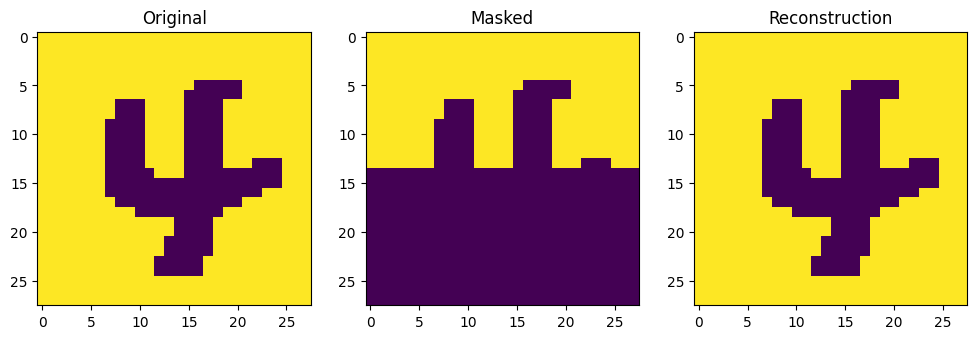

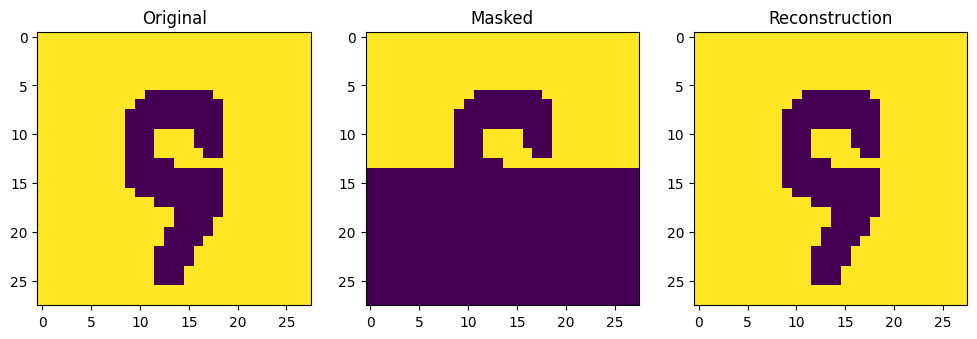

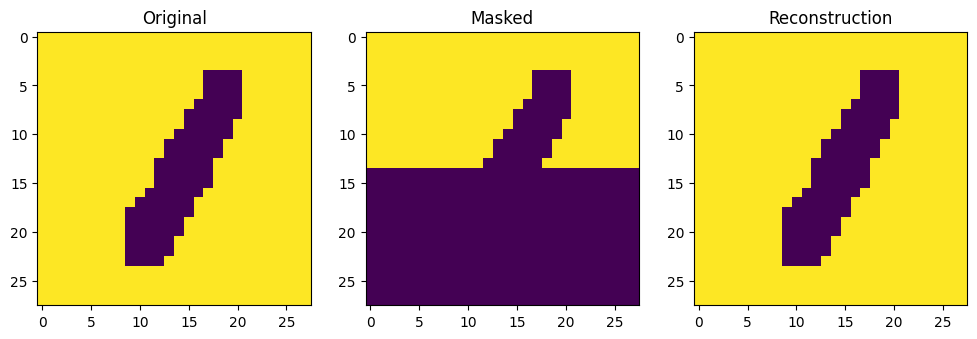

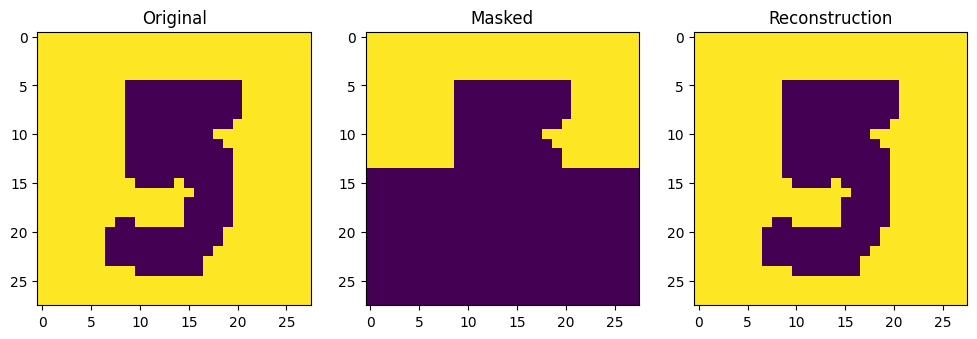

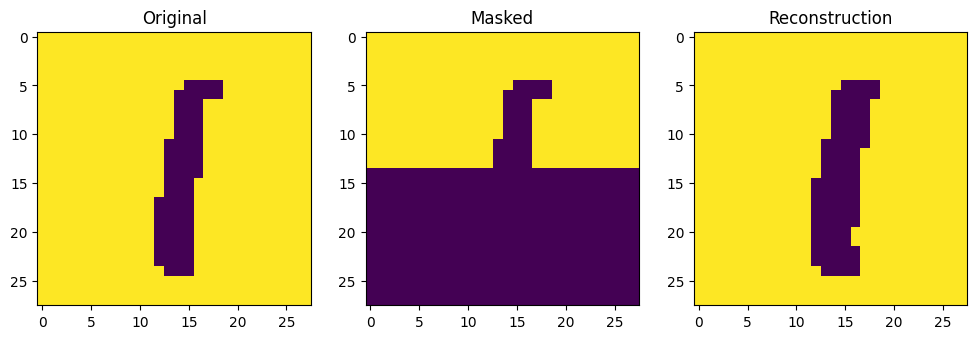

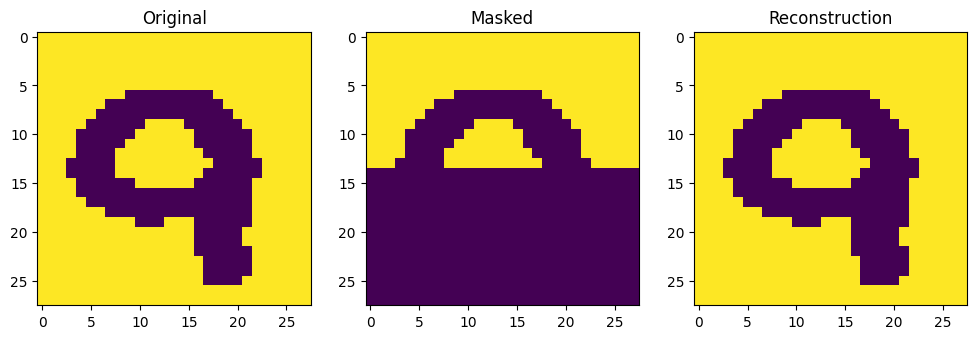

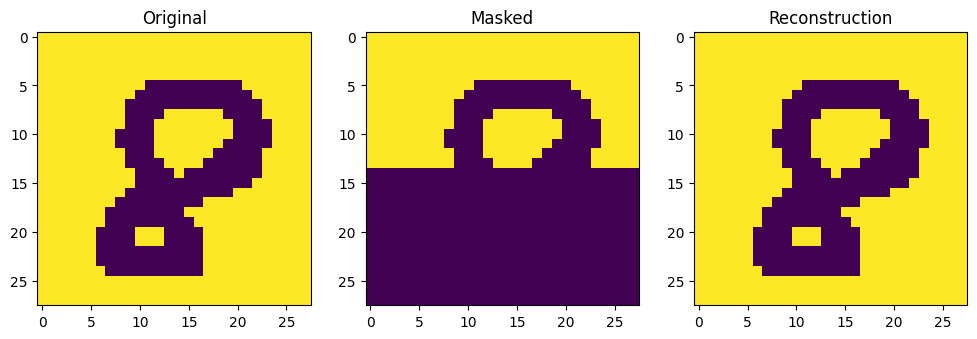

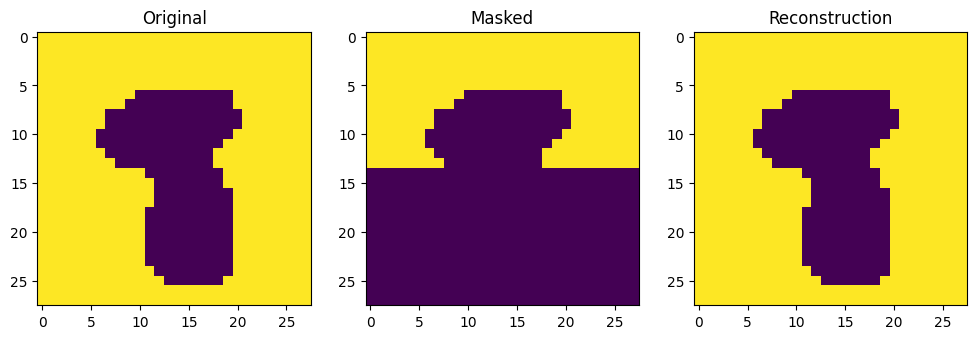

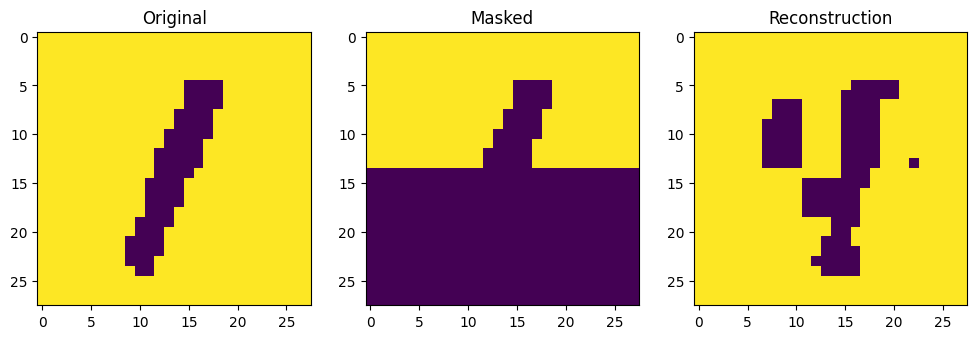

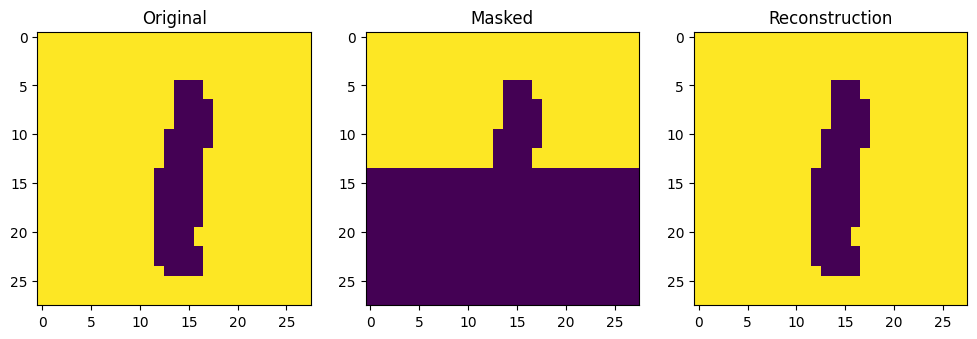

In [ ]:
def retrieve_store_demircigil(imgs,N,break_val=-1):
  xs = [binarize(imgs[i,:].reshape(784,1)) for i in range(N)]
  for j in range(N):
    # so we don't print a huge number of images for large stored patterns
    if break_val >0:
      if j > break_val:
        break
    halved_digit = zero_bottom_half(xs[j]).reshape(784,1)
    out = demircigil_update_rule(halved_digit,xs)
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    imgs = [xs[j], halved_digit, out]
    titles = ["Original","Masked","Reconstruction"]
    for i, ax in enumerate(axs.flatten()):
      plt.sca(ax)
      plt.imshow(imgs[i].reshape(28,28))
      plt.title(titles[i])
    plt.show()


retrieve_store_demircigil(imgs,10)

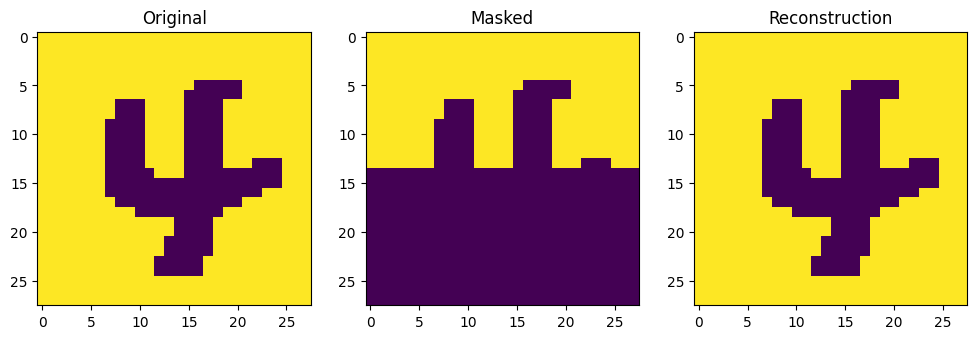

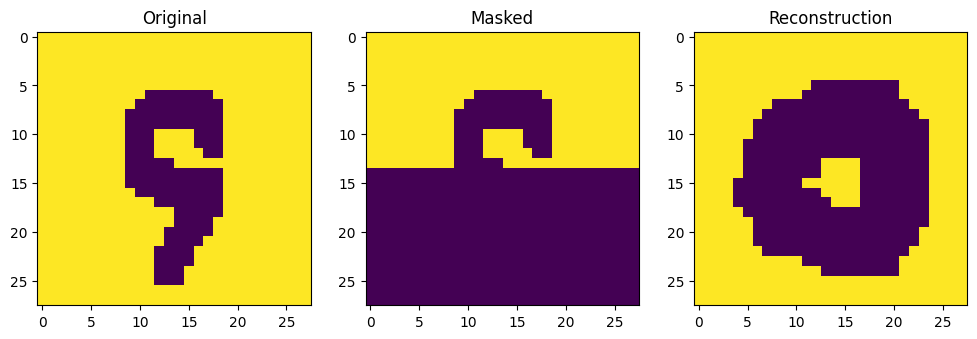

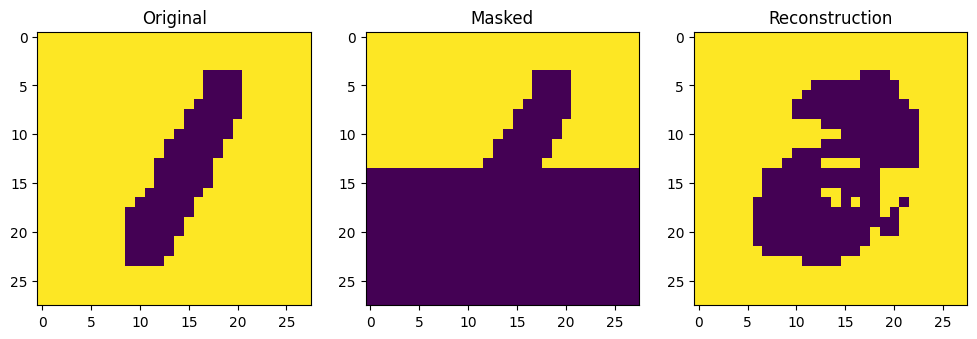

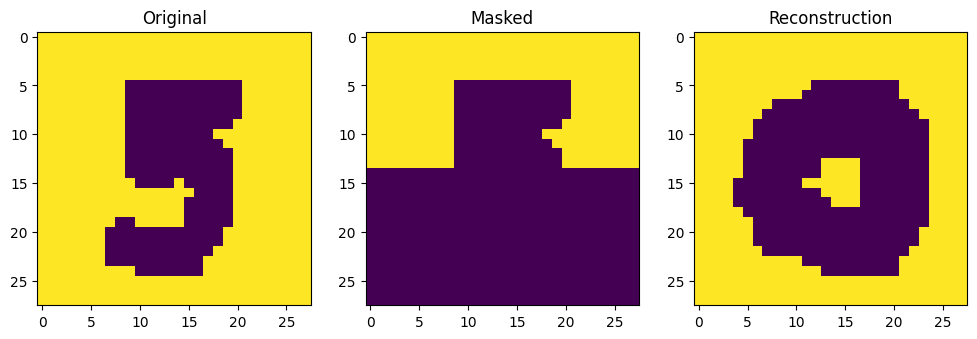

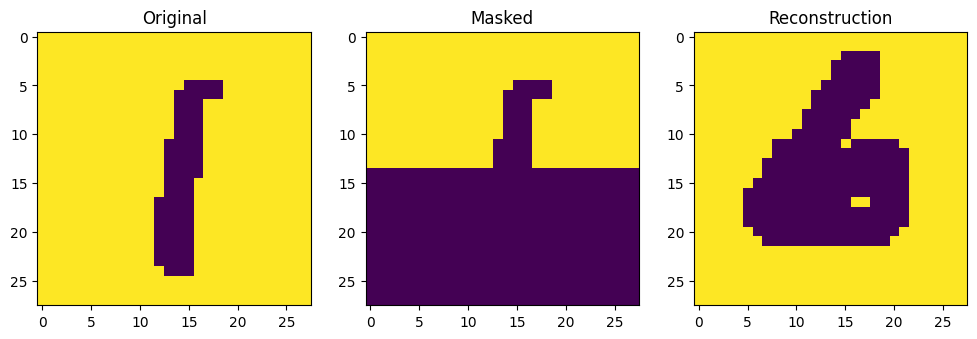

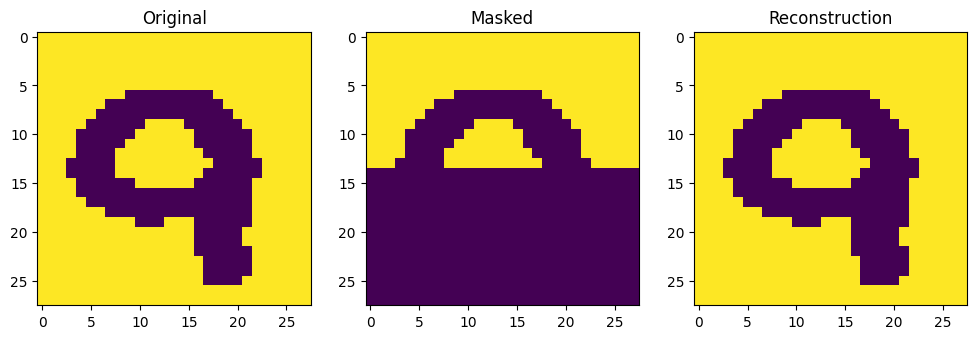

In [ ]:
retrieve_store_demircigil(imgs, 100,5)

# Continuous Modern Hopfield Networks

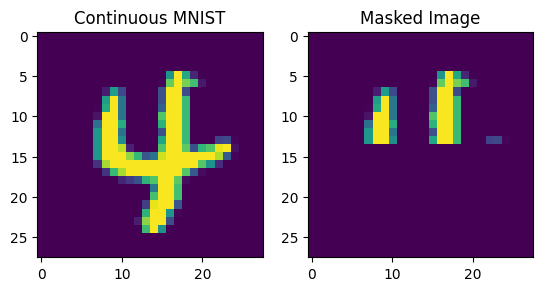

In [ ]:
def halve_continuous_img(img):
  H,W = img.reshape(28,28).shape
  i = deepcopy(img.reshape(28,28))
  i[H//2:H,:] = 0
  return i

xs = [imgs[i,:] for i in range(100)]
plt.subplot(1,2,1)
plt.imshow(xs[0].reshape(28,28))
plt.title("Continuous MNIST")
halved_img = halve_continuous_img(xs[0])
plt.subplot(1,2,2)
plt.title("Masked Image")
plt.imshow(halved_img)
plt.show()

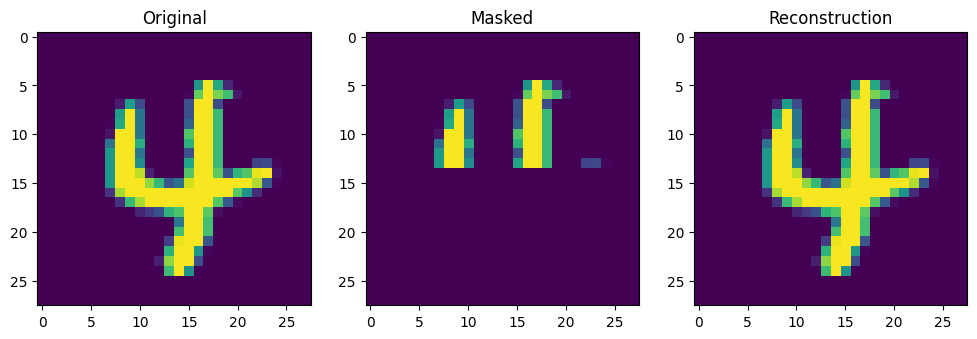

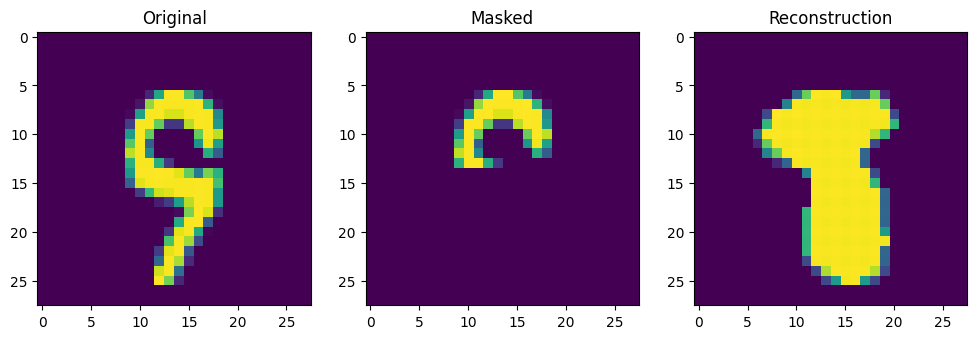

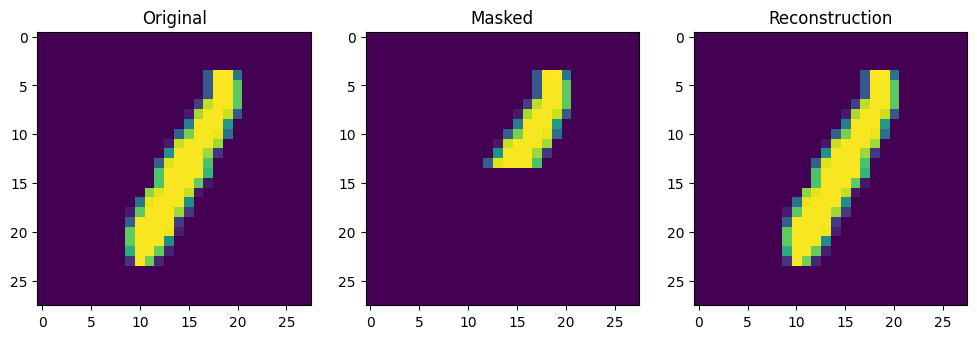

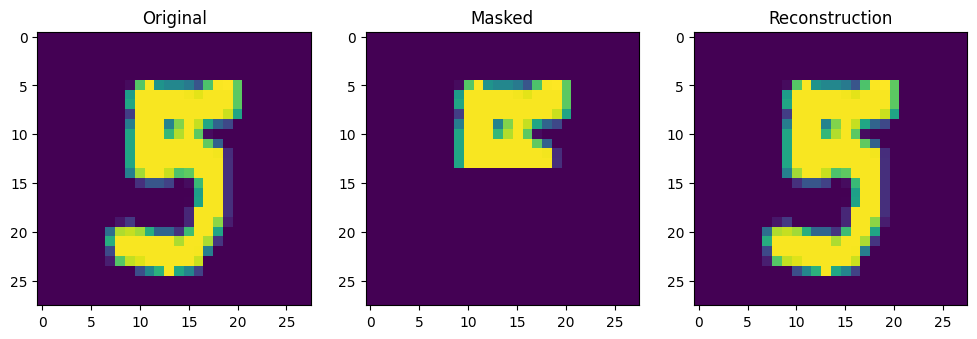

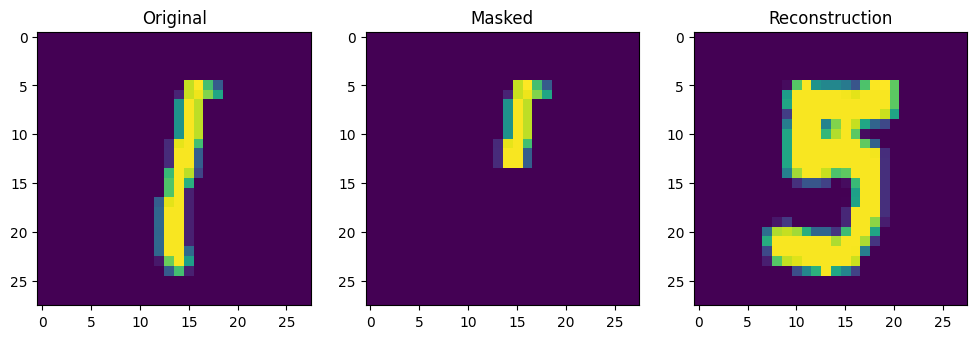

In [ ]:
# we next create our weight matrix and then do update rule to retrieve a half pattern
def continuous_update_rule(X,z,beta):
  return X.T @ F.softmax(beta * X @ z,dim=0)

def retrieve_store_continuous(imgs,N, beta=8,num_plot = 5):
  X = imgs[0:N,:]
  for j in range(num_plot):
    z = halve_continuous_img(X[j,:]).reshape(784,1)
    out = continuous_update_rule(X,z,beta)
    # plot
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    imgs = [X[j,:], z, out]
    titles = ["Original","Masked","Reconstruction"]
    for i, ax in enumerate(axs.flatten()):
      plt.sca(ax)
      plt.imshow(imgs[i].reshape(28,28))
      plt.title(titles[i])
    plt.show()

retrieve_store_continuous(imgs,10)

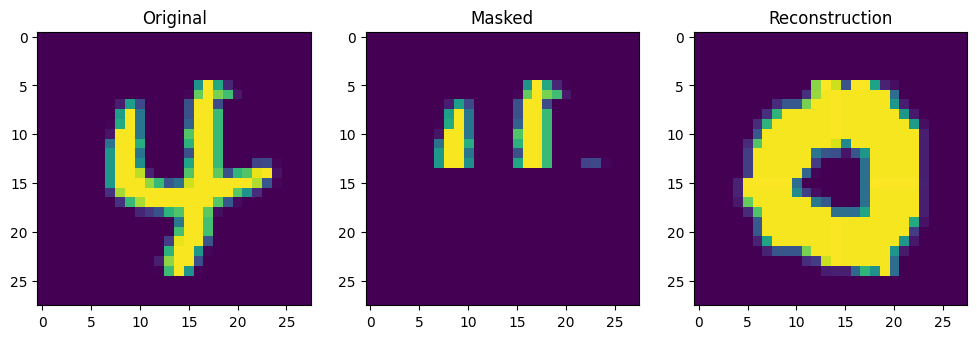

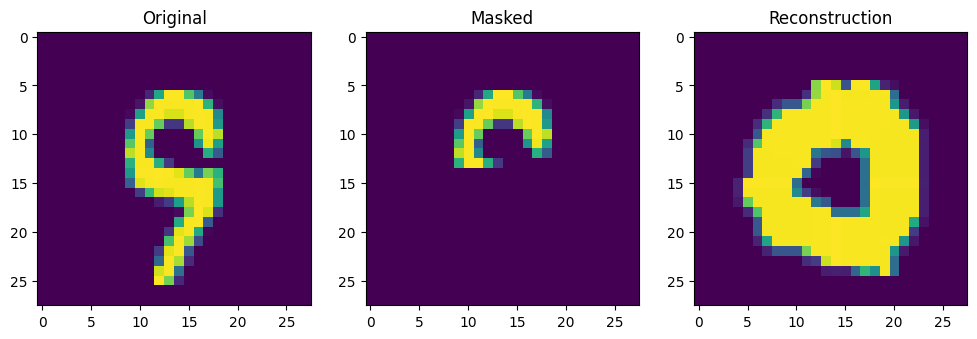

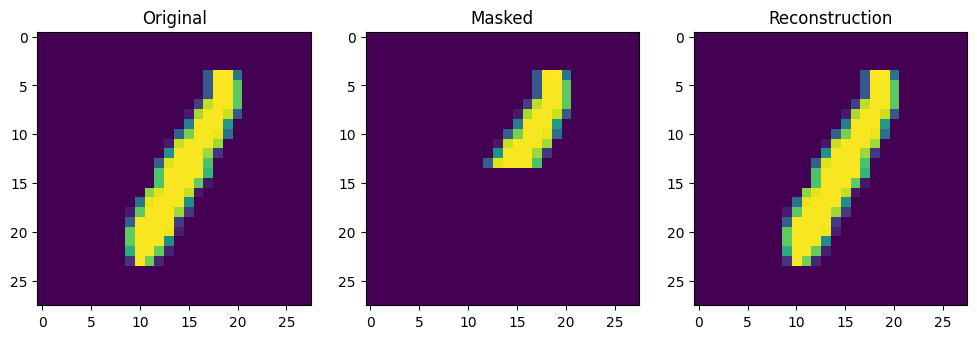

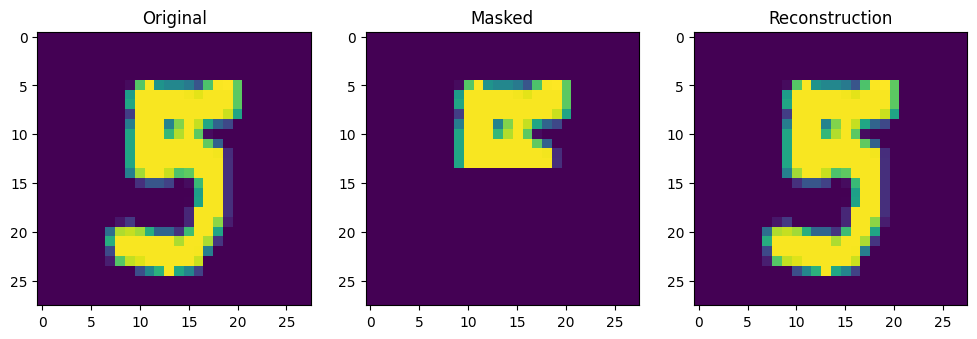

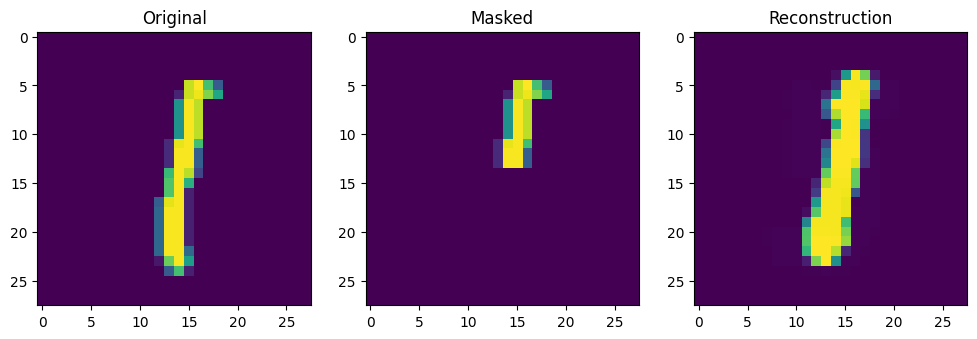

In [ ]:
retrieve_store_continuous(imgs, 100)

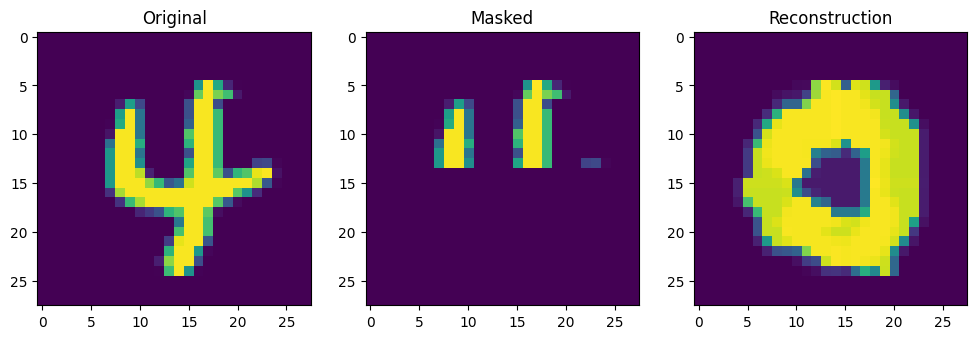

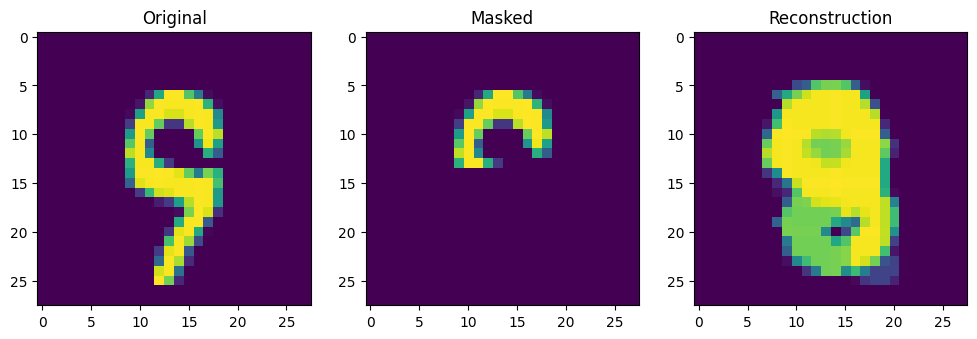

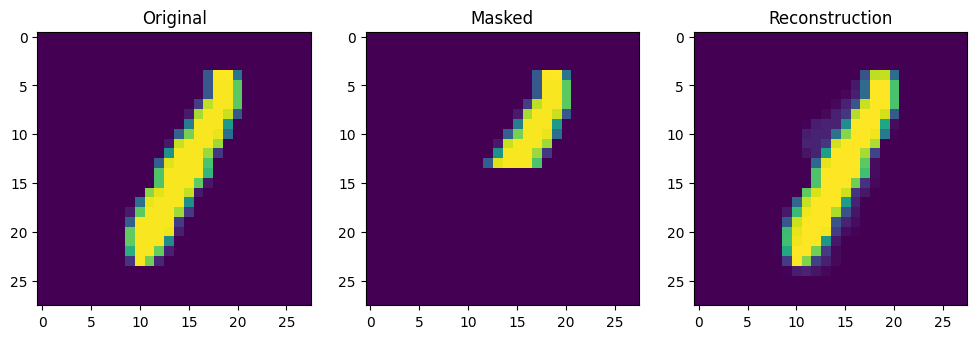

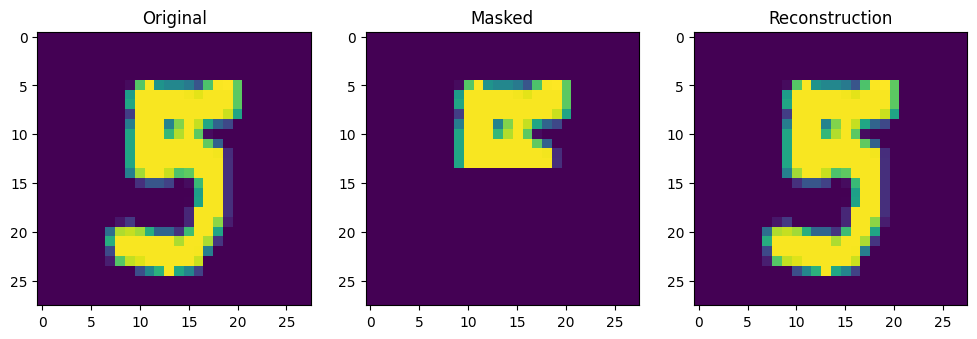

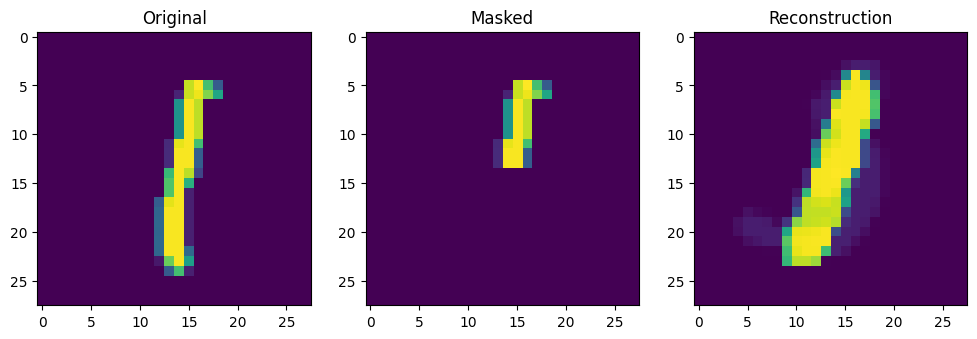

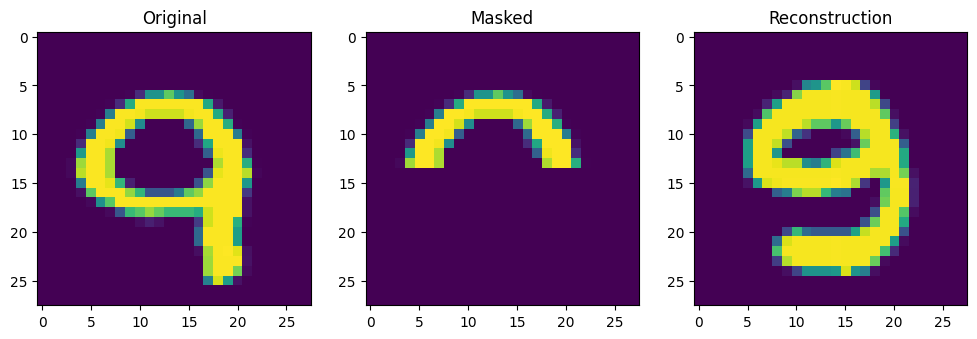

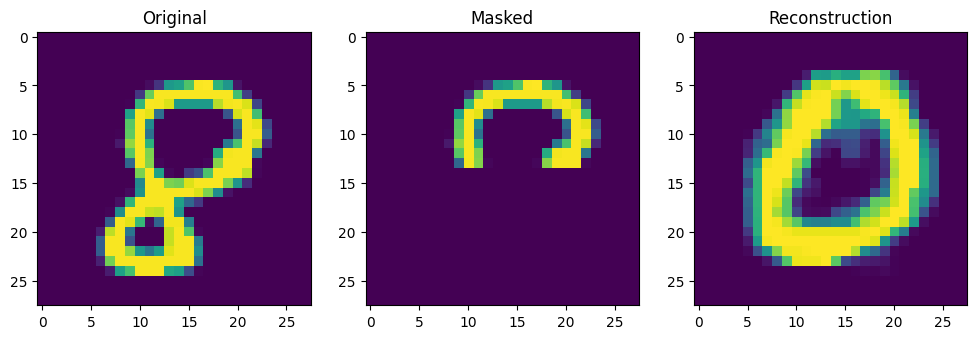

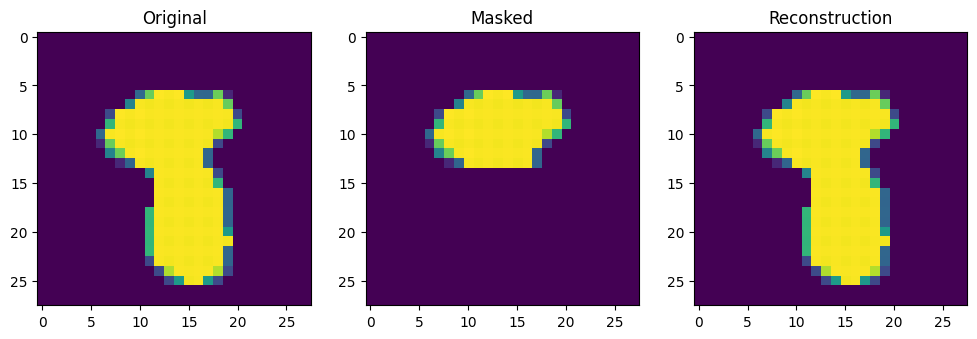

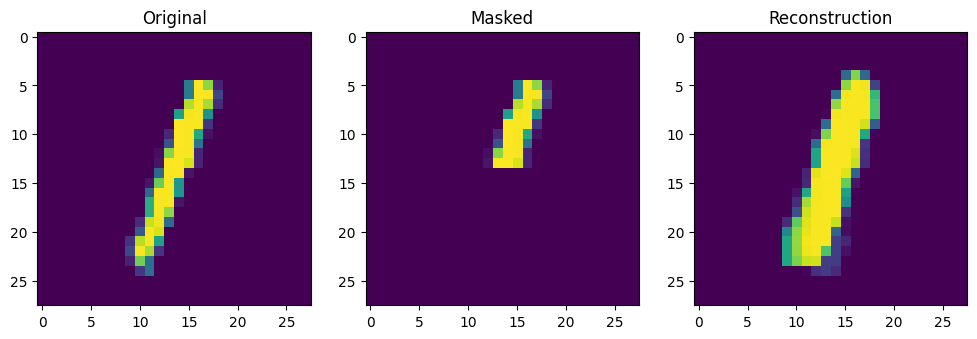

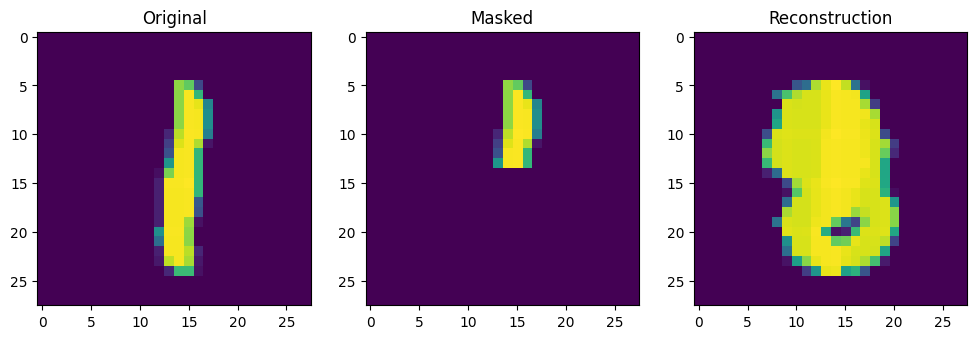

In [ ]:
retrieve_store_continuous(imgs, 1000, num_plot=10)

Beta:  0.1


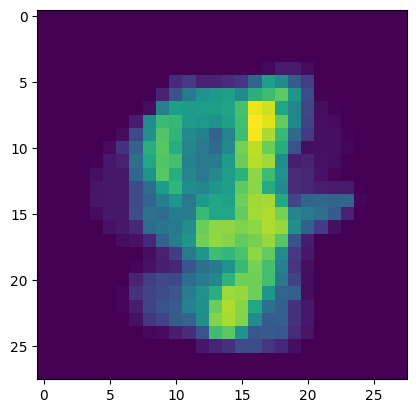

Beta:  0.2


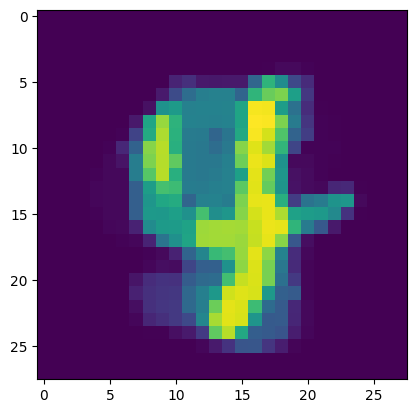

Beta:  0.5


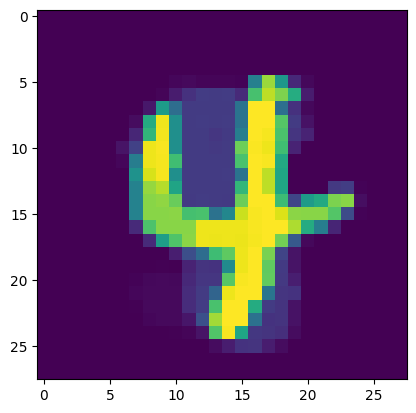

Beta:  1


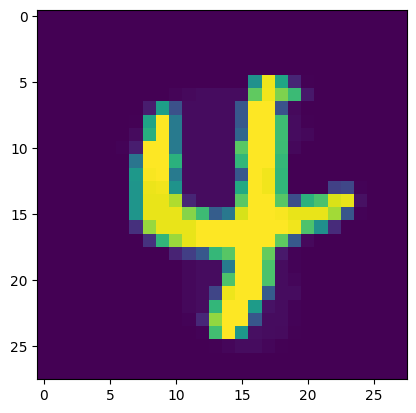

Beta:  2


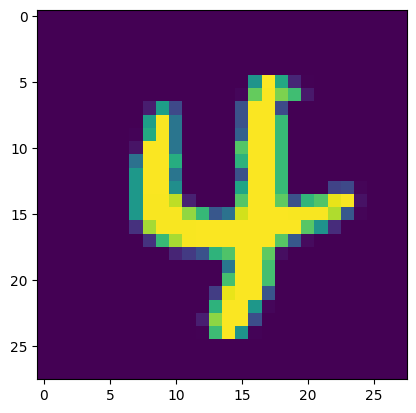

Beta:  4


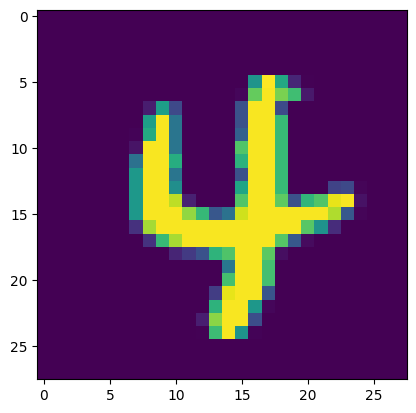

Beta:  8


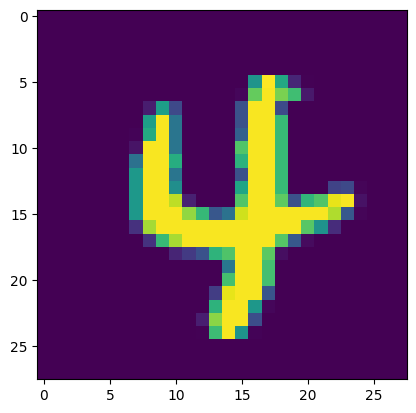

In [ ]:
# check effects of beta
betas = [0.1,0.2,0.5,1,2,4,8]
X = imgs[0:10,:]
z = halve_continuous_img(X[0,:]).reshape(784,1)
for beta in betas:
  print("Beta: ", beta)
  out = continuous_update_rule(X,z,beta)
  out = out.reshape(28,28)
  plt.imshow(out)
  plt.show()